In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import os
import os.path

df = pd.read_csv(f"../input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'])
df['quote_date']=pd.to_datetime(df['quote_date'])
df['delta'] = df['delta'].abs()

#########################
# Settings for backtest #
#########################
delta_sp = 0.06
delta_lp = 0.3
delta_sc = 0.02
delta_lc = 0.3

same_day = False
purchase_time = '15:45:00'

max_loss = 50.5

early_exit_criteria = {'max_loss': None}

commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0

In [2]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
        return pd.Series([0,0,0])
    return pd.Series([df1['strike'],df1['delta'],price])


def get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    total_lost = 0.0
    if underlying > strike_sc:
        total_lost = total_lost + (underlying - strike_sc)*100
        if underlying > strike_lc:
            total_lost = total_lost - (underlying - strike_lc)*100
    if underlying < strike_sp:
        total_lost = total_lost + (strike_sp - underlying)*100
        if underlying < strike_lp:
            total_lost = total_lost - (strike_lp - underlying)*100
    return total_lost

def get_amount_lost_minute(contract_date, strike_sp, strike_lp, strike_sc, strike_lc, curr_collected, curr_lost, curr_comm, quote_time, filtered_df):
    if curr_lost > 0.0:
        return pd.Series([curr_lost, curr_comm])
    
    if (quote_time == '16:00:00'):
        return pd.Series([get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc), curr_comm])
    
    df1 = filtered_df[(filtered_df['quote_date']==contract_date) & (filtered_df['expiration']==contract_date)]
    
    df_sp = df1[df1['strike']==strike_sp].min()
    price_sp = (df_sp['ask']+df_sp['bid'])/0.02
    
    df_lp = df1[df1['strike']==strike_lp].min()
    price_lp = (df_lp['ask']+df_lp['bid'])/0.02
    
    df_sc = df1[df1['strike']==strike_sc].min()
    price_sc = (df_sc['ask']+df_sc['bid'])/0.02
    
    df_lc = df1[df1['strike']==strike_lc].min()
    price_lc = (df_lc['ask']+df_lc['bid'])/0.02
    
    curr_cost_to_buy_back = price_sp - price_lp + price_sc - price_lc
    # return curr_value
    if curr_cost_to_buy_back >= (max_loss)*curr_collected:
        return pd.Series([curr_cost_to_buy_back, curr_comm*2])
    
    return pd.Series([0.0, curr_comm])

In [3]:
df_times = pd.DataFrame(df['quote_time'].unique())

df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1 + dte_f)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected_sc'] = 0.0
df_trades['collected_lc'] = 0.0
df_trades['collected_sp'] = 0.0
df_trades['collected_lp'] = 0.0
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['strike_sp'] = 0
df_trades['strike_lp'] = 0
df_trades['strike_sc'] = 0
df_trades['strike_lc'] = 0
df_trades['delta_sp'] = 0.0
df_trades['delta_lp'] = 0.0
df_trades['delta_sc'] = 0.0
df_trades['delta_lc'] = 0.0
df_trades['net'] = 0.0
df_trades['commission'] = 0.0

In [4]:
trade_count = 0

# Create new filtered dataframe with only calls above target delta
if delta_sc > 0.0:
    df_sc = df[(df['type']=="C") & (df['delta']>= delta_sc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_sc = df_sc.loc[df_sc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_sc = df_sc.loc[df_sc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    #apply dataframe to get strikes and collect premium
    df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sc), axis = 1).T.values
    trade_count = trade_count + 1

if delta_lc > 0.0:
    df_lc = df[(df['type']=="C") & (df['delta']>= delta_lc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_lc = df_lc.loc[df_lc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_lc = df_lc.loc[df_lc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    # apply dataframe to get strikes and collect premium
    df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lc), axis = 1).T.values
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_sp > 0.0:
    df_sp = df[(df['type']=="P") & (df['delta']>= delta_sp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_sp = df_sp.loc[df_sp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_sp = df_sp.loc[df_sp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sp), axis = 1).T.values
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_lp > 0.0:
    df_lp = df[(df['type']=="P") & (df['delta']>= delta_lp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_lp = df_lp.loc[df_lp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_lp = df_lp.loc[df_lp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lp), axis = 1).T.values
    trade_count = trade_count + 1

df_trades['collected'] = df_trades['collected_sc'] + -1*df_trades['collected_lc'] + df_trades['collected_sp'] + -1*df_trades['collected_lp']
df_trades['commission'] = trade_count * commission

In [5]:
for index, trow in df_times.iterrows():
    min_i = int(trow[0][3:5])
    curr_time = time(hour=int(trow[0][0:2]),minute=int(trow[0][3:5]),second=int(trow[0][6:]))
    start_time = time(hour=9, minute=45)
    end_time = time(hour=16)
    if (end_time < curr_time or curr_time <= start_time):
        continue
    filtered_df = df[(df['quote_time']==str(trow[0]))]
    df_trades['lost'], df_trades['commission'] = df_trades.apply(lambda row : get_amount_lost_minute(row['expiration'], row['strike_sp'], row['strike_lp'], row['strike_sc'], row['strike_lc'], row['collected'], row['lost'], row['commission'], str(trow[0]), filtered_df), axis=1).T.values
    
    # print(df_trades.head())
    
    if min_i % 30 == 0:
        print(f"processed {curr_time}")

processed 16:00:00


In [6]:
df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
                                                                                         
# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [7]:
df_trades.tail(50)

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,strike_sc,strike_lc,delta_sp,delta_lp,delta_sc,delta_lc,net,commission
62,2022-05-17,2022-05-16,50.0,1345.0,225.0,1380.0,-2450.0,0.0,3900.0,3970.0,4130.0,4040.0,0.0691,0.3007,0.0224,0.3133,-2462.0,12.0
63,2022-05-18,2022-05-17,40.0,1110.0,215.0,1285.0,-2140.0,-7500.0,3975.0,4050.0,4195.0,4115.0,0.0660,0.3006,0.0205,0.3018,5348.0,12.0
64,2022-05-19,2022-05-18,57.5,1445.0,270.0,1520.0,-2637.5,0.0,3790.0,3885.0,4075.0,3955.0,0.0680,0.3145,0.0210,0.3158,-2649.5,12.0
65,2022-05-20,2022-05-19,65.0,1460.0,212.5,1460.0,-2642.5,0.0,3795.0,3875.0,4070.0,3945.0,0.0627,0.3069,0.0227,0.3207,-2654.5,12.0
66,2022-05-23,2022-05-20,65.0,1540.0,235.0,1605.0,-2845.0,0.0,3750.0,3845.0,4050.0,3925.0,0.0601,0.3032,0.0222,0.3125,-2857.0,12.0
67,2022-05-24,2022-05-23,55.0,1275.0,207.5,1460.0,-2472.5,0.0,3850.0,3930.0,4080.0,3995.0,0.0632,0.3183,0.0249,0.3101,-2484.5,12.0
68,2022-05-25,2022-05-24,50.0,1295.0,215.0,1520.0,-2550.0,0.0,3830.0,3910.0,4075.0,3980.0,0.0641,0.3173,0.0214,0.3020,-2562.0,12.0
69,2022-05-26,2022-05-25,55.0,1205.0,190.0,1430.0,-2390.0,0.0,3875.0,3955.0,4100.0,4020.0,0.0601,0.3208,0.0254,0.3001,-2402.0,12.0
70,2022-05-27,2022-05-26,37.5,1035.0,200.0,1225.0,-2022.5,15.0,3960.0,4040.0,4165.0,4095.0,0.0635,0.3165,0.0215,0.3070,-2049.5,12.0
71,2022-05-31,2022-05-27,52.5,1265.0,220.0,1470.0,-2462.5,0.0,4025.0,4115.0,4260.0,4180.0,0.0618,0.3167,0.0249,0.3116,-2474.5,12.0


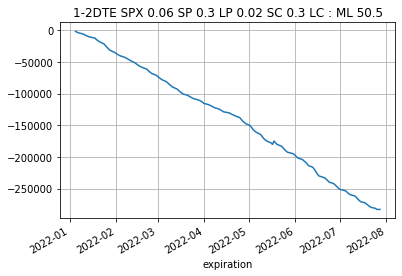

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
df_trade_plot.plot(ax=ax)
plt.title(f"{'0' if same_day else '1-2'}DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"{'0' if same_day else '1-2'}DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")